In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels tensorflow


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow. keras.models import Sequential
from tensorflow .keras.layers import LSTM, Dense, Dropout







In [3]:
# 1. Load Stock Market Data (columns: Date, Open, High, Low, Close, Volume, Turnover, P/E, P/B, Div Yield)
stock_data = pd.read_csv('nifty100_stock_data.csv', parse_dates=['Date'], index_col='Date')


In [6]:
# 2. Ensure the Date index has a frequency
#    We'll assume the data is daily. If you want business days only, use 'B' instead of 'D'.
stock_data = stock_data.asfreq('B').ffill()


In [5]:
# Quick look at the data
print(stock_data.head())
print(stock_data.info())

            Open  High  Low    Close  Volume  Turnover    P/E   P/B  Div Yield
Date                                                                          
2003-01-01   0.0   0.0  0.0  1000.00     NaN       NaN  14.04  2.14       2.73
2003-01-02   0.0   0.0  0.0  1008.03     NaN       NaN  14.15  2.16       2.71
2003-01-03   0.0   0.0  0.0  1004.49     NaN       NaN  14.10  2.15       2.72
2003-01-06   0.0   0.0  0.0   999.85     NaN       NaN  14.04  2.14       2.73
2003-01-07   0.0   0.0  0.0   997.81     NaN       NaN  14.01  2.14       2.74
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4528 entries, 2003-01-01 to 2020-05-08
Freq: B
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4528 non-null   float64
 1   High       4528 non-null   float64
 2   Low        4528 non-null   float64
 3   Close      4528 non-null   float64
 4   Volume     3820 non-null   float64
 5   Turnover   3820 non-null   flo

In [7]:
# Create daily returns
stock_data['daily_return'] = stock_data['Close'].pct_change(fill_method=None)
stock_data.dropna(inplace=True)  # Remove rows with NaN after pct_change

# Check columns
print("Data columns:", stock_data.columns)


Data columns: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Turnover', 'P/E', 'P/B',
       'Div Yield', 'daily_return'],
      dtype='object')


In [8]:
# We'll predict daily_return using multiple features
X = stock_data[['Open', 'High', 'Low', 'Volume', 'Turnover', 'P/E', 'P/B', 'Div Yield']]
y = stock_data['daily_return']

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (3056, 8)
Testing shape: (764, 8)


In [9]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.6f}")
print(f"Random Forest R^2: {r2_rf:.6f}")


Random Forest MSE: 0.000183
Random Forest R^2: 0.134380


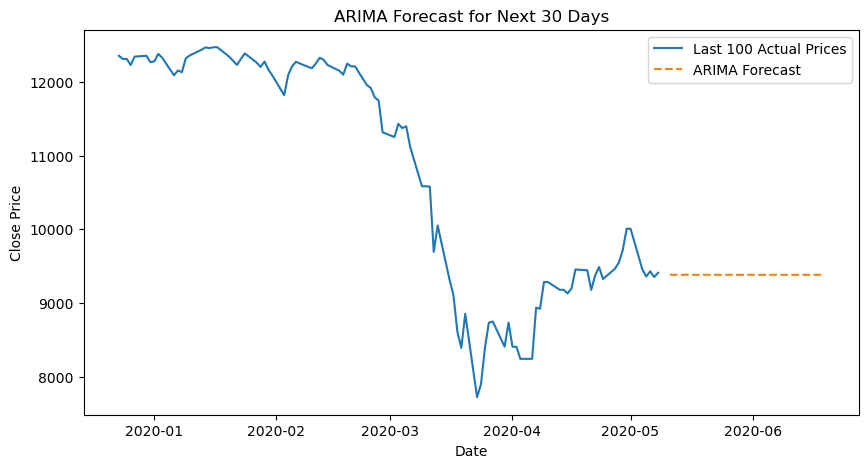

In [10]:
# ARIMA for Close price
arima_model = ARIMA(stock_data['Close'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Forecast next 30 business days
forecast_arima = arima_model_fit.forecast(steps=30)

# Plot ARIMA forecast
plt.figure(figsize=(10,5))
plt.plot(stock_data['Close'].tail(100), label='Last 100 Actual Prices')
plt.plot(forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [11]:
from sklearn.preprocessing import MinMaxScaler

# Scale the 'Close' price
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(stock_data[['Close']])


In [12]:
# Prepare LSTM data: 60 timesteps
X_lstm, y_lstm = [], []
for i in range(60, len(close_scaled)):
    X_lstm.append(close_scaled[i-60:i, 0])
    y_lstm.append(close_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

In [13]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0545
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0035
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0024
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0025
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0023
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0022
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0023
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0019
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0018
Epoch 10/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0020


In [15]:
# Save model
model.save('stock_lstm_model.keras')

print("✅ LSTM model saved: stock_lstm_model.keras")

✅ LSTM model saved: stock_lstm_model.keras


118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


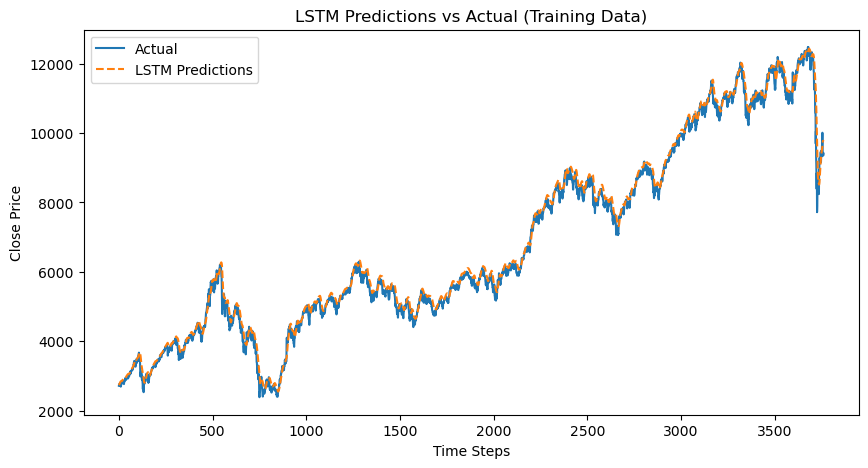

In [16]:
# Predictions on the same data (for demonstration only)
predictions = model.predict(X_lstm)
predictions = scaler.inverse_transform(predictions)  # back to original scale
actual = scaler.inverse_transform(y_lstm.reshape(-1, 1))

plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='LSTM Predictions', linestyle='--')
plt.title('LSTM Predictions vs Actual (Training Data)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()
